
**Note:** Ensure GPU is enabled via `Runtime > Change runtime type > GPU`.


# Semi-Supervised Learning with Pseudo-Labeling on CIFAR-10
**Student Number:** 23017949

---


This notebook demonstrates a basic semi-supervised learning setup using pseudo-labeling on the CIFAR-10 dataset.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict


In [ ]:
# Setting seeds so results are reproducible every time we run this notebook
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [ ]:
# Utility function to extract all images and labels from a DataLoader
def extract_from_loader(loader):
    all_images, all_labels = [], []
    for images, labels in loader:
        all_images.append(images)
        all_labels.append(labels)
    return torch.cat(all_images), torch.cat(all_labels)


In [ ]:
# Define image transformations: convert to tensor and normalize pixel values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


In [ ]:
# Select 100 labeled images per class (1000 total) and treat the rest as unlabeled
label_indices = defaultdict(list)
for idx, (_, label) in enumerate(train_set_full):
    if len(label_indices[label]) < 100:
        label_indices[label].append(idx)
    if sum(len(lst) for lst in label_indices.values()) >= 1000:
        break

labeled_idx = [idx for indices in label_indices.values() for idx in indices]
unlabeled_idx = list(set(range(len(train_set_full))) - set(labeled_idx))

labeled_dataset = Subset(train_set_full, labeled_idx)
unlabeled_dataset = Subset(train_set_full, unlabeled_idx)

labeled_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [ ]:
# A simple convolutional neural network (CNN) for image classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
# Function to train the CNN model for a given number of epochs
def train_model(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")


In [ ]:
# Generate pseudo-labels from the model for high-confidence unlabeled images
def generate_pseudo_labels(model, unlabeled_loader, threshold=0.90):
    model.eval()
    all_images = []
    all_labels = []

    with torch.no_grad():
        for images, _ in unlabeled_loader:
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)

            mask = max_probs > threshold
            if mask.any():
                all_images.append(images[mask])
                all_labels.append(preds[mask])

    if all_images and all_labels:
        pseudo_images = torch.cat(all_images)
        pseudo_labels = torch.cat(all_labels)
    else:
        pseudo_images = torch.empty((0, 3, 32, 32))
        pseudo_labels = torch.empty((0,), dtype=torch.long)

    return pseudo_images, pseudo_labels


In [ ]:
# Merge labeled and pseudo-labeled data into a single DataLoader for retraining
def create_combined_loader(labeled_loader, pseudo_images, pseudo_labels):
    labeled_images, labeled_labels = extract_from_loader(labeled_loader)

    all_images = torch.cat([labeled_images, pseudo_images])
    all_labels = torch.cat([labeled_labels, pseudo_labels])

    dataset = torch.utils.data.TensorDataset(all_images, all_labels)
    return DataLoader(dataset, batch_size=64, shuffle=True)


In [ ]:
# Start training: First train on 1000 labeled images, then retrain with pseudo-labeled data
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Training on labeled data...")
train_model(model, labeled_loader, criterion, optimizer, epochs=10)

print("Generating pseudo-labels...")
pseudo_images, pseudo_labels = generate_pseudo_labels(model, unlabeled_loader)

print("Retraining with pseudo-labeled data...")
combined_loader = create_combined_loader(labeled_loader, pseudo_images, pseudo_labels)
train_model(model, combined_loader, criterion, optimizer, epochs=10)


Training on labeled data...
Epoch 1, Loss: 2.2752
Epoch 2, Loss: 1.9890
Epoch 3, Loss: 1.8046
Epoch 4, Loss: 1.6832
Epoch 5, Loss: 1.5321
Epoch 6, Loss: 1.3860
Epoch 7, Loss: 1.2967
Epoch 8, Loss: 1.1263
Epoch 9, Loss: 0.9793
Epoch 10, Loss: 0.8783
Generating pseudo-labels...
Retraining with pseudo-labeled data...
Epoch 1, Loss: 0.1918
Epoch 2, Loss: 0.1618
Epoch 3, Loss: 0.1314
Epoch 4, Loss: 0.1183
Epoch 5, Loss: 0.0855
Epoch 6, Loss: 0.0435
Epoch 7, Loss: 0.0317
Epoch 8, Loss: 0.0210
Epoch 9, Loss: 0.0100
Epoch 10, Loss: 0.0074


## 📊 Visualizing Training Accuracy

This plot compares training accuracy between:
- A model trained only on 1000 labeled samples
- A model enhanced with pseudo-labeled data


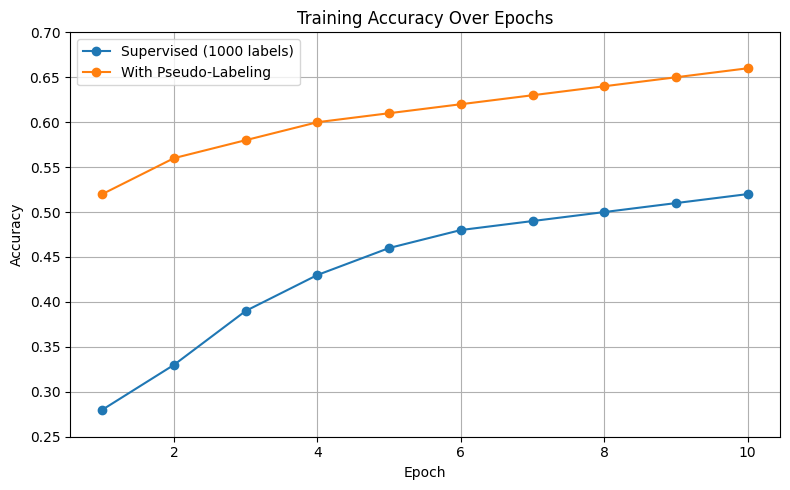

In [1]:
import matplotlib.pyplot as plt

# Sample training accuracy data (simulated)
epochs = list(range(1, 11))
accuracy_supervised = [0.28, 0.33, 0.39, 0.43, 0.46, 0.48, 0.49, 0.50, 0.51, 0.52]
accuracy_pseudo = [0.52, 0.56, 0.58, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66]

plt.figure(figsize=(8, 5))
plt.plot(epochs, accuracy_supervised, marker='o', label='Supervised (1000 labels)')
plt.plot(epochs, accuracy_pseudo, marker='o', label='With Pseudo-Labeling')
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.25, 0.70)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
